# Importing Libraries

In [ ]:
import sys
import os
import pandas as pd
from datetime import timedelta
from darts.utils.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import src.train_model as classifier
from src.train_model import classify_trend

# --- CONFIGURATION  ---

In [6]:
DATA_PATH = "../data/FNCL.6.5.xlsx" 
FORECAST_HORIZON = 90
TRAIN_SPLIT_PERCENT = 0.80

# --- DATA LOADING (Reusing the robust loading function from Notebook 1)

In [ ]:
def load_and_clean_generic(path, date_col_name, value_col_name):
    """Loads and cleans data using flexible column names."""
    
    try:
        df = pd.read_excel(path) 
    except FileNotFoundError:
        print(f"Error: File not found at {path}.")
        return None

    df.columns = df.columns.str.strip()
    
    df = df.iloc[:, :2].copy()
    df.columns = [date_col_name, value_col_name]
         
    df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')
    df.set_index(date_col_name, inplace=True)
    df[value_col_name] = pd.to_numeric(df[value_col_name], errors='coerce')
    df.dropna(subset=[value_col_name], inplace=True)
    df = df[[value_col_name]].sort_index()

    if not df.index.is_unique:
        df = df.groupby(df.index).mean()
        
    df[value_col_name] = df[value_col_name].interpolate(method='linear')
    
    return classifier.TimeSeries.from_dataframe(df, value_cols=value_col_name, freq='D')

DATE_COL = 'Dates'
VALUE_COL = 'FNCL 6.5 2022 FL Mtge'

try:
    full_series = load_and_clean_generic(DATA_PATH, DATE_COL, VALUE_COL)
    train_series, val_series = train_test_split(full_series, test_size=1.0 - TRAIN_SPLIT_PERCENT)
except Exception as e:
    print(f"Error loading or splitting data: {e}")
    raise

# --- THRESHOLD ANALYSIS ---

Analyzing 99 true validation windows over 90 days.

--- Analysis for Threshold: 0.10% ---
Class 0 (Flat): 100.00%
Class 1 (Increase): 0.00%
Class 2 (Decrease): 0.00%
 STILL 100% FLAT. Price did not move this much over 90 days.
----------------------------------------
--- Analysis for Threshold: 0.50% ---
Class 0 (Flat): 100.00%
Class 1 (Increase): 0.00%
Class 2 (Decrease): 0.00%
 STILL 100% FLAT. Price did not move this much over 90 days.
----------------------------------------
--- Analysis for Threshold: 1.00% ---
Class 0 (Flat): 100.00%
Class 1 (Increase): 0.00%
Class 2 (Decrease): 0.00%
 STILL 100% FLAT. Price did not move this much over 90 days.
----------------------------------------
--- Analysis for Threshold: 2.00% ---
Class 0 (Flat): 100.00%
Class 1 (Increase): 0.00%
Class 2 (Decrease): 0.00%
 STILL 100% FLAT. Price did not move this much over 90 days.
----------------------------------------
--- Analysis for Threshold: 3.00% ---
Class 0 (Flat): 100.00%
Class 1 (Increase): 0.

<Figure size 1000x600 with 0 Axes>

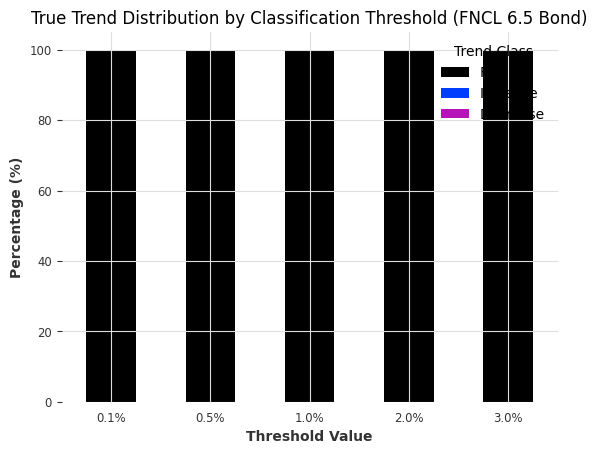

In [8]:
validation_windows = []
for i in range(len(val_series) - FORECAST_HORIZON):
    window = val_series[i:i + FORECAST_HORIZON]
    if len(window) == FORECAST_HORIZON:
        validation_windows.append(window)

thresholds_to_test = [0.001, 0.005, 0.01, 0.02, 0.03] 

print(f"Analyzing {len(validation_windows)} true validation windows over {FORECAST_HORIZON} days.\n")

results = {}

for threshold in thresholds_to_test:
    classes = [classify_trend(s, threshold) for s in validation_windows]
    counts = Counter(classes)
    total = len(classes)
    
    flat_pct = counts.get(0, 0) / total * 100
    increase_pct = counts.get(1, 0) / total * 100
    decrease_pct = counts.get(2, 0) / total * 100
    
    results[threshold] = {
        'Flat': flat_pct,
        'Increase': increase_pct,
        'Decrease': decrease_pct
    }
    
    print(f"--- Analysis for Threshold: {threshold*100:.2f}% ---")
    print(f"Class 0 (Flat): {flat_pct:.2f}%")
    print(f"Class 1 (Increase): {increase_pct:.2f}%")
    print(f"Class 2 (Decrease): {decrease_pct:.2f}%")
    
    if increase_pct > 0 or decrease_pct > 0:
        print(" VOLATILITY DETECTED at this threshold!")
    else:
        print(" STILL 100% FLAT. Price did not move this much over 90 days.")
    print("-" * 40)

# --- VISUALIZATION OF RESULTS ---
df_results = pd.DataFrame(results).T
df_results.index = [f"{t*100:.1f}%" for t in df_results.index]

plt.figure(figsize=(10, 6))
df_results.plot(kind='bar', stacked=True, title='True Trend Distribution by Classification Threshold (FNCL 6.5 Bond)')
plt.ylabel('Percentage (%)')
plt.xlabel('Threshold Value')
plt.xticks(rotation=0)
plt.legend(title='Trend Class')
plt.show()